## Text Analysis Task 2B

### 0. Prepare 1000 documents

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'rec.motorcycles', 'sci.space', ]
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

data = dataset.data[:1000]
labels = dataset.target[:1000]
print("Original document:\n")
print(data[0])
for i in range(len(data)):
    data[i] = data[i].split()
print("\nDocument after spliting:\n")
print(data[0])

Original document:

From: da709@cleveland.Freenet.Edu (Stephen Amadei)
Subject: Project Help
Organization: Case Western Reserve University, Cleveland, Ohio (USA)
Lines: 17
NNTP-Posting-Host: hela.ins.cwru.edu


Hello, 
 
I am new to this news group, but I need some info.  I am 
currently doing a project for a class on the Internet.  I am
looking for good sources of information on space and astronomy,
more notably, our own solar system.  If anyone knows any good
sites where I can get information about this kinda stuff, please 
e-mail me at STK1663@VAX003.STOCKTON.EDU.  Thanx.
 
                                ----Steve
 
(my newsreader doesn't have a .sig yet, sorry.)
-- 
Please Address repondes to Stk1600@Vax003.Stockton.Edu
                                     or
                           Adonchey@Faatcrl.Faa.Gov


Document after spliting:

['From:', 'da709@cleveland.Freenet.Edu', '(Stephen', 'Amadei)', 'Subject:', 'Project', 'Help', 'Organization:', 'Case', 'Western', 'Reserve', 'Un

### 1. Data preprocessing

In [2]:
import nltk
import string
from nltk.corpus import wordnet as wn

en_stop = nltk.corpus.stopwords.words('english')

en_stop = ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<", "|", "="]                  \
         + ["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         + ["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         + en_stop

def preprocess_word(word, stopwordset):
    
    #1.convert words to lowercase
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopwords
    word = word.translate(str.maketrans('', '', string.punctuation))
    if word in stopwordset:
        return None
    
    #4.lemmatize
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    # lemmatized words could be in the stopwords set
    elif lemma in stopwordset: 
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

In [ ]:
import gensim
from gensim import corpora

dictionary = corpora.Dictionary(preprocess_documents(data))
corpus_ = [dictionary.doc2bow(doc) for doc in preprocess_documents(data)]
print(dictionary.token2id)

### 2. LDA

### 1) Training

In [85]:
k = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=k,
                                           id2word=dictionary,
                                           alpha=30,                 # optional LDA hyperparameter alpha
                                           eta=0.01,                   # optional LDA hyperparameter beta
                                           #minimum_probability=0.0    # optional the lower bound of the topic/word generative probability
                                          )

### 2) Check out the result

In [86]:
# the top num_words of words for each topic (topic ID, the word generative probability for the topic).

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.057*"" + 0.008*"subject" + 0.007*"organization" + 0.007*"line" + 0.005*"space" + 0.005*"would" + 0.005*"write" + 0.005*"image" + 0.004*"one" + 0.004*"get" + 0.004*"nntppostinghost" + 0.003*"like" + 0.003*"use" + 0.003*"bike" + 0.003*"need"')
(1, '0.074*"" + 0.008*"image" + 0.006*"line" + 0.006*"organization" + 0.005*"subject" + 0.005*"write" + 0.004*"space" + 0.004*"get" + 0.004*"would" + 0.004*"file" + 0.004*"article" + 0.004*"jpeg" + 0.003*"one" + 0.003*"like" + 0.003*"nntppostinghost"')
(2, '0.053*"" + 0.008*"line" + 0.008*"subject" + 0.006*"write" + 0.006*"organization" + 0.005*"article" + 0.005*"get" + 0.004*"one" + 0.004*"would" + 0.004*"image" + 0.004*"file" + 0.003*"like" + 0.003*"university" + 0.003*"make" + 0.003*"dont"')


In [87]:
from nltk.corpus import reuters as corpus

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    #print(ldamodel.get_document_topics(item))
# the categories of documents
categories = [corpus.categories(fileid) for fileid in corpus.fileids()]

document ID 0:document ID 1:document ID 2:document ID 3:document ID 4:document ID 5:document ID 6:document ID 7:document ID 8:document ID 9:

In [88]:
n=2

# nth document's topic distribution
print(ldamodel.get_document_topics(corpus_[n]))

# nth document's category
print(categories[n])

# show the original document
print(" ".join(data[n]))

[(0, 0.333404), (1, 0.32781184), (2, 0.3387841)]
['crude', 'nat-gas']
From: tdawson@engin.umich.edu (Chris Herringshaw) Subject: WingCommanderII Graphics Organization: University of Michigan Engineering, Ann Arbor Lines: 8 Distribution: world NNTP-Posting-Host: antithesis.engin.umich.edu I was wondering if anyone knows where I can get more information about the graphics in the WingCommander series, and the RealSpace system they use. I think it's really awesome, and wouldn't mind being able to use similar features in programs. Thanks in advance. Daemon


### 3) Visualization

In [89]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [90]:
cv_tmp = CoherenceModel(model=ldamodel, texts=preprocess_documents(data), dictionary=dictionary, coherence='c_v')
coh = cv_tmp.get_coherence()
print(coh)

0.43729998490037086


### 4) Evaluation

In [33]:
def evaluation(k):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=k,
                                           id2word=dictionary,
                                           alpha=50 / k,                 # optional LDA hyperparameter alpha
                                           eta=0.01,                   # optional LDA hyperparameter beta
                                           #minimum_probability=0.0    # optional the lower bound of the topic/word generative probability
                                          )
    perplexity = ldamodel.log_perplexity(corpus_)
    cv_tmp = CoherenceModel(model=ldamodel, texts=preprocess_documents(data), dictionary=dictionary, coherence='c_v')
    coh = cv_tmp.get_coherence()
    return(perplexity, coh)

In [34]:
import math

perplexity = [0] * 10
coherence = [0] * 10
for k in range(10):
    perplexity[k], coherence[k] = evaluation(k + 1)

(1, 9)

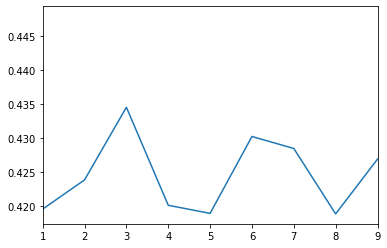

In [65]:
import matplotlib.pyplot as plt

plt.plot(coherence)
plt.xlim((1, 9))

